In [1]:
import numpy as np

all_tasks_results = np.load('cka_results.npy')

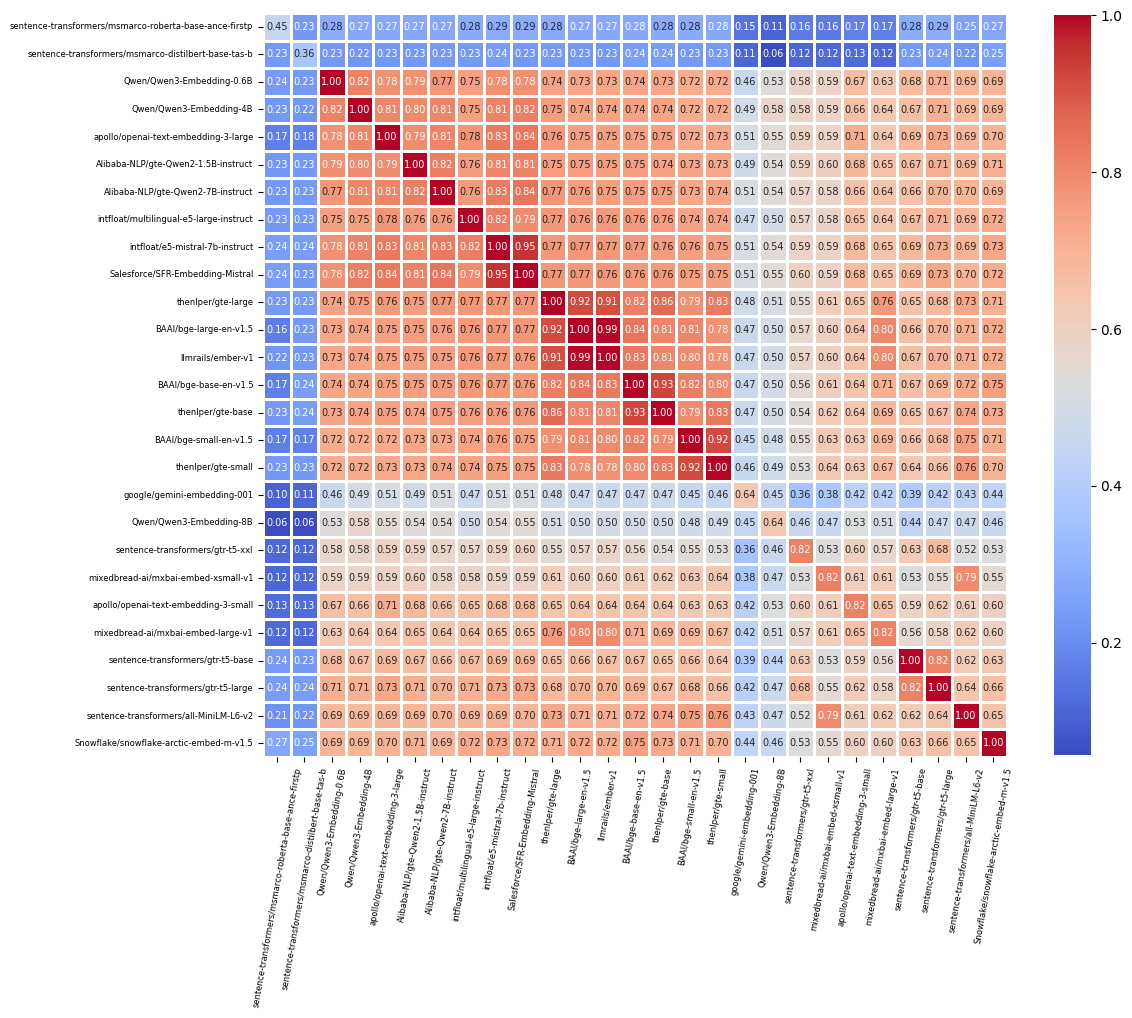

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from matplotlib.colors import LinearSegmentedColormap
from config.eval import MODELS

aggregated_distances = np.nan_to_num(all_tasks_results, 0).mean(axis=0)
nan_mask = (aggregated_distances == 0).mean(0) != 1
aggregated_distances = aggregated_distances[nan_mask][:, nan_mask]

link = linkage(aggregated_distances, method='ward')
cluster_order = leaves_list(link)
aggregated_distances = aggregated_distances[cluster_order][:, cluster_order]

order = np.array(np.array(MODELS)[nan_mask])[cluster_order]


plt.figure(figsize=(12, 12))
mask = np.eye(aggregated_distances.shape[0], dtype=bool)

sns.heatmap(
    aggregated_distances,
    #mask=mask,
    cmap="coolwarm", #cmap,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7},
    square=True,
    linewidths=0.8,
    linecolor='white',
    cbar_kws={"shrink": 0.8},
    xticklabels=order, yticklabels=order
)
plt.xticks(fontsize=6, rotation=80)
plt.yticks(fontsize=6)
plt.show()

In [3]:
import yaml
with open("config/model_details.yaml", "r") as file:
        model_details = yaml.safe_load(file)

In [4]:
# Results data
aggregated_distances = np.nan_to_num(all_tasks_results, 0).mean(axis=0)
nan_mask = (aggregated_distances == 0).mean(0) != 1
aggregated_distances = aggregated_distances[nan_mask][:, nan_mask]

# Get families
models = model_details.keys()
model_families = [model_details[m]["model_family"] for m in model_details.keys()]
mapping = {k: v for k,v in zip(models, model_families)}

# Model family according to the order in the heatmap
model_families = [mapping[m] for m in np.array(MODELS)[nan_mask]]

In [5]:
results = []

families = np.unique(model_families)
np.fill_diagonal(aggregated_distances, np.nan)
for family in families:
    results_per_family = []
    for family2 in families:
        select_src = np.array(model_families) == family
        select_tgt = np.array(model_families) == family2
        distances = aggregated_distances[select_src][:, select_tgt]
        
        if len(distances) > 1:
            mean_dist = np.nanmean(distances)
        else:
            mean_dist = float('nan')
        results_per_family.append(mean_dist)
    results.append(results_per_family)

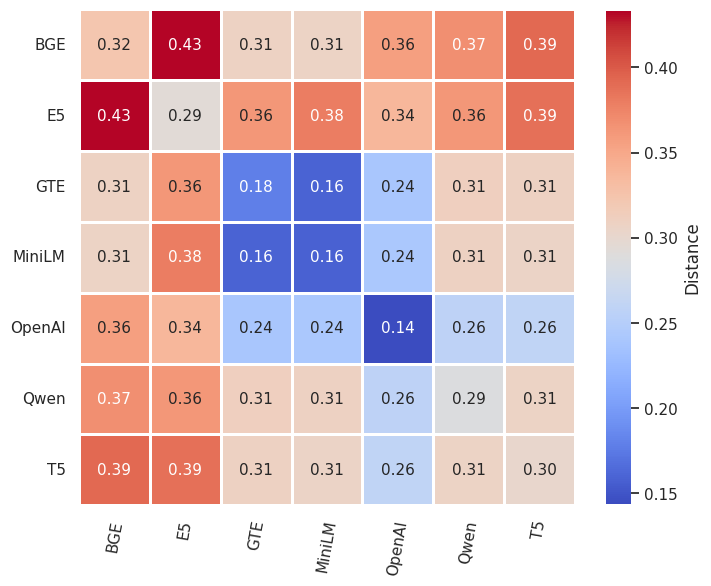

In [6]:
import pandas as pd

sns.set(style='whitegrid')
# Get family matrix
family_matrix = pd.DataFrame(results, columns=families, index=families).fillna(1)
family_matrix.index = family_matrix.columns
family_matrix_np = family_matrix.values

rows_to_drop = family_matrix.columns[(family_matrix == 1).all(axis=1)]
family_matrix_dropped = family_matrix.drop(columns=rows_to_drop, index=rows_to_drop)


link = linkage(family_matrix_dropped, method='ward')
order = leaves_list(link)
reordered = family_matrix_dropped.iloc[order].iloc[:, order]
new_ticks = np.array(family_matrix_dropped.columns)[order]
plt.figure(figsize=(8, 8))

sns.heatmap(
    1 - reordered,
    annot=True,
    fmt=".2f",
    cmap="coolwarm", #cmap,
    annot_kws={"size": 11},
    square=True,
    linewidths=0.8,
    linecolor='white',
    cbar_kws={"shrink": 0.8, "label": "Distance"},  
    xticklabels=family_matrix_dropped.columns, yticklabels=family_matrix_dropped.columns
)
plt.xticks(fontsize=11, rotation=80)
plt.yticks(fontsize=11, rotation=0)
plt.savefig("paper/figures/cka.pdf", dpi=300, bbox_inches='tight')
plt.show()